# File name classification example - using basic Machine Learning tools

This Notebook demonstrates how a simple dataset can be transformed into a form that basic Machine Learning (ML) tools can work with. 

The dataset is created by the Python class `FilenameFactory`, which outputs file names that are classified as either "good" (1: they match the expected structure) or "bad" (0: they do not match the expected structure).

This example uses a range of different classifiers (*simple* ML models that predict a *class* (rather than a *value*)) from the [scikit-learn](https://scikit-learn.org/) library (also known as `sklearn`). These classifiers require the input data to be in a numeric form (typically as a `numpy.array` or `pandas.DataFrame`). 

The role of this Notebook is to demonstrate:
1. Generation of a synthetic dataset.
2. Transformation of an example (text-based) dataset into a form ready for use by an ML model.
3. Splitting the dataset into *training* and *test* sets.
4. Running a selection of different ML classifiers.
5. Selecting the *best* classifier based on (compute) time taken and accuracy score.
6. Evaluating the best classifier on the *test* dataset.
7. Making predictions on new data, where the *class* of the records are not known.

## Future plans for this project

Here is a possible to-do list for this project:
- [ ] Refactor to use a proper `sklearn` pipeline.
- [ ] I have added in a 5th type of error file (with reversed "c1" value) - this has improved the performance of the SGD classifier because it now has extra training data. This is a good example of how you can examine the model and training to improve things.
- [ ] Expand into using a Deep Learning model that is trained on a wide range of file names. Then allow transfer learning techniques to *tune* versions of the model for specific projects.


## Library imports

The initial imports include some Python standard library packages and some data science favourites (`pandas`, `numpy` and `matplotlib`).

In [1]:
%matplotlib inline
# Imports
import time
import os
import string
import random
random.seed(4)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Creating some synthetic data

The `FilenameFactory` class can typically be used to return a *good* or *bad* file, as follows:

```python
ff = FilenameFactory()
good_file = ff.create()
bad_file = ff.create(bad=True)
```

A good file name follows these rules:
1. Has 4 components separated by underscores.
2. Has a valid extension, one of `[".nc", ".csv"]`.
3. The last component should be a year between 2000 and 2030.


In [2]:
class FilenameFactory:
    """
    Class to generate good and bad files.
    """

    c1 = ["tas", "tasmax", "tasmin", "pr", "slhf"]
    c2 = ["ukcp", "cmip", "era"]
    c3 = ["5km", "25km", "60km", "100km"]
    c4 = [str(year) for year in range(2000, 2031)]
    ext = [".nc", ".csv"]

    def __init__(self):
        self.n_features = -1

    def create(self, bad=False, **kwargs):
        """
        Returns a good or bad file name.
        """
        d = {x: kwargs.get(x, random.choice(getattr(self, x))) for x in 
                        ["c1", "c2", "c3", "c4", "ext"]}

        if bad:
            err_type = random.choice(range(0, 5))
            if err_type == 0: # some components missing
                parts = [d.get(x) for x in ["c1", "c2", "c3", "c4"]]
                return "_".join(random.sample(parts, random.choice([1, 2, 3]))) + d["ext"]
            elif err_type == 1: # no extension
                d["ext"] = ""
            elif err_type == 2: # invalid extension
                d["ext"] = "." + "".join(random.sample(string.ascii_lowercase, 3))
            elif err_type == 3: # text instead of year
                d["c4"] = "".join(random.sample(string.ascii_lowercase, 4))
            elif err_type == 4: # no reversed "c1" value (so not known in vocab)
                d["c1"] = d["c1"][::-1]

        return "{c1}_{c2}_{c3}_{c4}{ext}".format(**d)

    def create_batch(self, n=10000, n_bad=0):
        """
        Returns `n` file names, of which `n_bad` will be bad.
        
        Returns a tuple of the two lists split as: ([<good_files>], [<bad_files>]).
        """
        bad_files = [self.create(bad=True) for i in range(n_bad)]
        good_files = [self.create() for i in range((n - n_bad))]

        print(f"Good: {len(good_files)}, Bad: {len(bad_files)}, All: {len(good_files) + len(bad_files)}")
        return good_files, bad_files

    def _filelist_to_df(self, file_list):
        """
        Takes in a file list and returns a valid `pandas.DataFrame`.
        Note: all missing features (columns) or extensions will default to "".
        """
        # Create a DUMMY record temporarily, just in case a single file does not
        # have enough features. Cope with this by using preset `self.n_features`
        USED_DUMMY = False
        if len(file_list) == 1:
            dummy = "_".join(["x" for i in range(self.n_features)]) + ".ext"
            file_list.insert(0, dummy)
            USED_DUMMY = True

        # Create a data frame from the file list
        df = pd.DataFrame(file_list, columns=["filename"])
        self.n_features = max([max([s.count("_") for s in file_list]) + 1, self.n_features])

        # Create a temporary column removing the extension - which is then split into feature columns
        df["fname_no_ext"] = df["filename"].apply(lambda fname: os.path.splitext(fname)[0])
        df[[f"feature_{i}" for i in range(1, self.n_features + 1)]] = df["fname_no_ext"].str.split("_", expand=True)

        # Add the extension as a column
        df["ext"] = df["filename"].apply(lambda fname: os.path.splitext(fname)[-1].lstrip("."))

        # If DUMMY was used, then drop the first record (the dummy)
        if USED_DUMMY:
            df = df.iloc[1:]

        # Drop superfluous columns and fill all empty fields with "", then reindex and return
        df = df.drop(columns=["filename", "fname_no_ext"])
        df = df.fillna(value="").reset_index(drop=True)
        return df

    def filename_to_df(self, filename):
        """
        Convert a single file name to a `pandas.DataFrame`.
        """
        return self._filelist_to_df([filename])
        
    def get_ai_ready_batch(self, n=10000, n_bad=0):
        """
        Generate `n` file names (of which `n_bad` are bad), and convert them to
        a `pandas.DataFrame`.

        The columns are: ["feature_1", "feature_2", ..., "feature_n", "ext", "is_good"]
        """
        good_files, bad_files = self.create_batch(n=n, n_bad=n_bad)

        # Now convert to a Pandas DataFrame
        df = self._filelist_to_df(good_files + bad_files)

        df["is_good"] = 1
        df.loc[len(good_files):, ["is_good"]] = 0
        df = df.sort_values(by="feature_1").reset_index(drop=True)
        return df

Let's create an instance of the factory and create some example file names...

In [3]:
ff = FilenameFactory()

In [4]:
good_files, bad_files = ff.create_batch(n_bad=20)

Good: 9980, Bad: 20, All: 10000


In [5]:
df = ff.get_ai_ready_batch(n=10, n_bad=2)
one_rec_df = ff.filename_to_df("hello_or_other.nc")
one_rec_df

Good: 8, Bad: 2, All: 10


,feature_1,feature_2,feature_3,feature_4,ext
0,hello,or,other,,nc


And let's see what some **bad files** look like:

In [6]:
for i in range(10):
    print(bad_files[i])

tasmax_cmip_5km_ecam.csv
slhf_cmip_5km_2007.yfd
tasmin_ukcp_5km_2026.gfj
tasmin_era_60km_qhfp.csv
nimsat_ukcp_60km_2000.csv
nimsat_era_25km_2013.csv
tasmin_cmip_100km_2005.izb
sat_ukcp_100km_2020.csv
slhf_era_100km_2022
tasmax_ukcp_100km_ifln.nc


Now, let's extract an AI-ready `pandas.DataFrame` ready for some ML models. We'll create a total of 20,000 file names (20% of which will be *bad*).

In [7]:
df = ff.get_ai_ready_batch(n=20000, n_bad=4000)

# Look at some random records
df.iloc[[0, 9000, 7000, 5000, 3000]].head()

Good: 16000, Bad: 4000, All: 20000


,feature_1,feature_2,feature_3,feature_4,ext,is_good
0,100km,ukcp,,,csv,0
9000,tas,cmip,5km,2018,nc,1
7000,slhf,era,100km,2013,csv,1
5000,slhf,cmip,5km,2025,cfh,0
3000,pr,era,100km,2027,csv,1


## So, how would an ML model make sense of this dataset?

### Encoding the dataset

In general, a simple ML model would:
- not be able to accept data as text strings.
- expect to read data as a `DataFrame` or `numpy` array.
- would expect the data to be represented in a way in which each field in the above table would have an *equal weighting*.

Because of the last point, we need to be careful if we convert the strings into numerical values. For example, we could convert the values of `feature_1` as follows:
- "100km" --> 1
- "tas" --> 2
- "slhf" --> 3
- "pr" --> 4

The problem with that approach is that the model will assume that the numeric value of "pr" is much greater than that for "100km". We would therefore be providing the model with false and misleading information.

The usual solution to this problem is apply a data transformation known as [*one-hot-encoding*](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). We will use this approach to convert the data structure into something that the various classifiers can work with (which will not introduce bias0.

### Understanding the dataset in terms of *features* and a *target*

In *supervised learning*, it is usually the case the input dataset arrives as a table, containing:
- **features**: as the columns, except for the last one, which is the
- **target**: this is the result that we want our model to learn to *predict*
- **records**: as the rows, each record relates to one instance of our data (e.g. a file name)

So, our dataset has 5 features (4 components of the file names, and one file extension), one target (`is_good`) column (which has a value of 0 or 1). There are 20,000 records (file names).

In [8]:
df.iloc[100:105].head()

,feature_1,feature_2,feature_3,feature_4,ext,is_good
100,2009,cmip,25km,,nc,0
101,2009,,,,csv,0
102,2009,pr,era,,nc,0
103,2009,era,100km,,csv,0
104,2009,,,,nc,0


## One-hot-encoding

First, we'll create a class that contains our one-hot-encoder. It knows about the type of data we are working with, so it can be used for both *training* data (for training), *test* data (for evaluation) and future *unseen* data (for prediction). 

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
class FilenameOneHotEncoder:
    """
    A wrapper around the sklearn OneHotEncoder.
    Once we have an instance of this class, it can be used to
    transform data in training, testing and prediction phases.
    """

    def __init__(self, df, target="is_good"):
        self.target_name = target
        self.enc = OneHotEncoder(handle_unknown="ignore")

        self.df = self._drop_target(df)
        self.columns = list(self.df.columns)
        self.enc.fit(self.df)

    def _drop_target(self, df):
        df = df.copy()
        if self.target_name in df.columns:
            df = df.drop(columns=[self.target_name])

        return df

    def transform(self, df):
        df = self._drop_target(df)
        features_encoded = self.enc.transform(df).toarray()
        features = pd.DataFrame(features_encoded, 
                                columns=self.enc.get_feature_names_out(self.columns))
        return features

In [11]:
# Let's create our one-hot-encoder instance for future use.
one_hot_encoder = FilenameOneHotEncoder(df, target="is_good")

Let's do a quick demonstration of the one-hot-encoder for a dataset with two records:

In [12]:
# Quick test it works for new file names
df_newfile = ff.filename_to_df("pr_ukcp_25km_2000.nc")
df_enc = one_hot_encoder.transform(df_newfile)

print("This slice of the one-hot-encoded DataFrame contains 1 for `feature_1_pr`, and 0s for others...")
df_enc.iloc[:, 38:45].astype(np.int64)

This slice of the one-hot-encoded DataFrame contains 1 for `feature_1_pr`, and 0s for others...


,feature_1_nimsat,feature_1_pr,feature_1_rp,feature_1_sat,feature_1_slhf,feature_1_tas,feature_1_tasmax
0,0,1,0,0,0,0,0


## Splitting the dataset

In ML, it is convention to split the dataset into:
- **training set**: for selecting and training models, and tuning their hyperparameters (i.e. the parameters that can be tweaked for each model type).
- **test set**: used on the final chosen model, to evaluate how well it performs on unseen data.

Typically, you might split the overall dataset into 70% for training and 30% for testing. There are various more sophisticated methods of doing this that are beyond the scope of this tutorial.

In [13]:
from sklearn.model_selection import train_test_split


def split_data(df, one_hot_encoder=one_hot_encoder):
    """
    Split the input dataset into 4 components:
    - X_train: the feature columns of training data
    - X_test:  the feature columns of the test data
    - y_train: the target column of the training data
    - y_test:  the target column of the test data

    Note: the default `one_hot_encoder` is the global instance created above.

    Return as a tuple: (X_train, X_test, y_train, y_test)
    """
    features = one_hot_encoder.transform(df)
    target = df["is_good"].copy()

    # We switch on stratify=True so that both the training and test datasets
    # have an equal distribution of good and bad files
    X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                        test_size=0.3, random_state=42, 
                                                        shuffle=True, stratify=target)
    return X_train, X_test, y_train, y_test

In [14]:
# Split our data
X_train, X_test, y_train, y_test = split_data(df)

**NOTE**: we put the test data (`X_test` and `y_test`) to one side and don't touch it until we are evaluating the final model.

## What does our transformed dataset look like?

The `X_train` dataset has 14,000 rows, which is 70% of the total 20,000 rows provided in the input dataset. That was the test/train split we specified above.

We now have data transformed into a form that an ML model can handle. There are 1,739 columns, because we have one-hot-encoded the data. All the values of the training data are either ones or zeros.

In [15]:
X_train.shape, y_train.shape

((14000, 1739), (14000,))

In [16]:
print("Let's check the first three records makes sense...")
df_3_recs = X_train.iloc[:3]
df_3_recs.iloc[:3].loc[:, (df_3_recs != 0).any(axis=0)].join(y_train.iloc[:3]).astype(np.int64)

Let's check the first three records makes sense...


,feature_1_pr,feature_1_tas,feature_2_cmip,feature_2_ukcp,feature_3_100km,feature_3_25km,feature_3_5km,feature_4_2005,feature_4_2012,feature_4_2027,ext_,ext_csv,ext_nc,is_good
3261,1,0,1,0,0,0,1,0,1,0,1,0,0,0
11791,0,1,1,0,1,0,0,0,0,1,0,1,0,1
11805,0,1,0,1,0,1,0,1,0,0,0,0,1,1


## The data is now prepared for an ML model, let's try a range of different models

Here, we import and select a range of different Machine Learning models from the `scikit-learn` (import a `sklearn`) library.

For each model (known as a *classifier*), we:
1. Create an instance of the classifier, with some initial parameters set (known as "hyperparameters" in the ML world).
2. Train the classififer on the 70% of data used as *training* data.
3. Then evaluate the *score* for the classifier by using the *test* data (i.e. the *unseen* 30% of the data).

Useful sources:
- Plot classifier comparison in [sklearn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- [Supervised learning in sklearn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)

**NOTE**: we include a `Dummy` classifier, which predicts the most frequent target (i.e. "good" files). This is useful to understand whether the measure of accuracy being achieved by a classifier is actually better than a constant/random guess.

In [33]:
# Import a selection of different models
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Import a range of metrics that could be used to compare models
from sklearn.metrics import (r2_score, mean_squared_error, root_mean_squared_error, 
                            accuracy_score, f1_score, precision_score, recall_score,
                            balanced_accuracy_score)

In [39]:
# Names for our classifiers
names = [
    "Dummy",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Gaussian Naive Bayes",
    "QDA",
    "Stochastic Gradient Descent"
]

# sklearn classifier class instances (with some hyperparameters set)
classifiers = [
    DummyClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(random_state=42),
]

# Examples of different scorers for assessing performance
scorers = {
    "accuracy": accuracy_score,
    "r2": r2_score,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "precision": precision_score,
    "recall": recall_score,
    "balanced_accuracy": balanced_accuracy_score,
    "f1": f1_score
}

In [40]:
results_columns = ["classifier", "duration", "score"] + list(scorers.keys())
results_file = "results_1.csv"

if os.path.isfile(results_file):
    print(f"Loading results from: {results_file}")
    results_df = pd.read_csv(results_file)
else:
    print("Generating results by running each classifier...")
    results_df = pd.DataFrame([], columns=results_columns, dtype=np.float64)
    results_df["classifier"] = results_df["classifier"].astype(str)
    
    print(results_columns)
    
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        print(f"Running: {name}")
        start = time.time()
        clf.fit(X_train, y_train)
        y_predictions = clf.predict(X_test)
        clf_score = clf.score(X_test, y_test)
        duration = time.time() - start
    
        results = [name, duration, clf_score] + [scorers[scorer](y_test, y_predictions) for scorer in scorers]
        print(results)
        
        results_df.loc[len(results_df), results_df.columns] = results
    
    print(f"Caching results for later, to {results_file}")
    results_df.to_csv(results_file, index=False)

Loading results from: results_1.csv


Let's plot the results and work out which look like the best classifiers...

In [41]:
rdf = results_df.copy()

The `score_duration_metric` column is a measure that tries to balance out the cost of a model (in terms of time - or CPU/energy use) versus the accuracty score.

In [42]:
rdf["score_duration_metric"] = (rdf["score"] - rdf["score"].min() + 0.0001) / (rdf["duration"] / rdf["duration"].max())

## Plotting a comparison of the classifiers and their results

The following plot shows the `score_duration_metric` in black, which is considered our favoured measure of how cheap and accurate a model is. The green line shows a threshold above which we are happy to use the results.

Top classifiers (at the top of the table), taking into account the duration (and CPU cost)...


,classifier,duration,score,accuracy,r2,mse,rmse,precision,recall,balanced_accuracy,f1,score_duration_metric
10,Stochastic Gradient Descent,0.594,1.000,1.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,168.748
8,Gaussian Naive Bayes,1.307,0.922,0.922,0.515,0.078,0.279,0.912,1.000,0.806,0.954,46.929
4,Decision Tree,2.166,0.904,0.904,0.401,0.096,0.310,0.893,1.000,0.760,0.943,24.116
0,Dummy,0.004,0.800,0.800,-0.250,0.200,0.447,0.800,1.000,0.500,0.889,12.527
9,QDA,14.855,0.923,0.923,0.518,0.077,0.278,0.912,1.000,0.807,0.954,4.145
1,Nearest Neighbors,10.390,0.883,0.883,0.268,0.117,0.342,0.873,0.999,0.708,0.932,3.998
6,Neural Net,57.158,0.968,0.968,0.797,0.032,0.180,0.961,1.000,0.919,0.980,1.469
7,AdaBoost,39.161,0.879,0.879,0.245,0.121,0.348,0.869,1.000,0.698,0.930,1.014
2,Linear SVM,81.883,0.958,0.958,0.741,0.042,0.204,0.951,1.000,0.896,0.975,0.970
5,Random Forest,0.289,0.800,0.800,-0.250,0.200,0.447,0.800,1.000,0.500,0.889,0.173


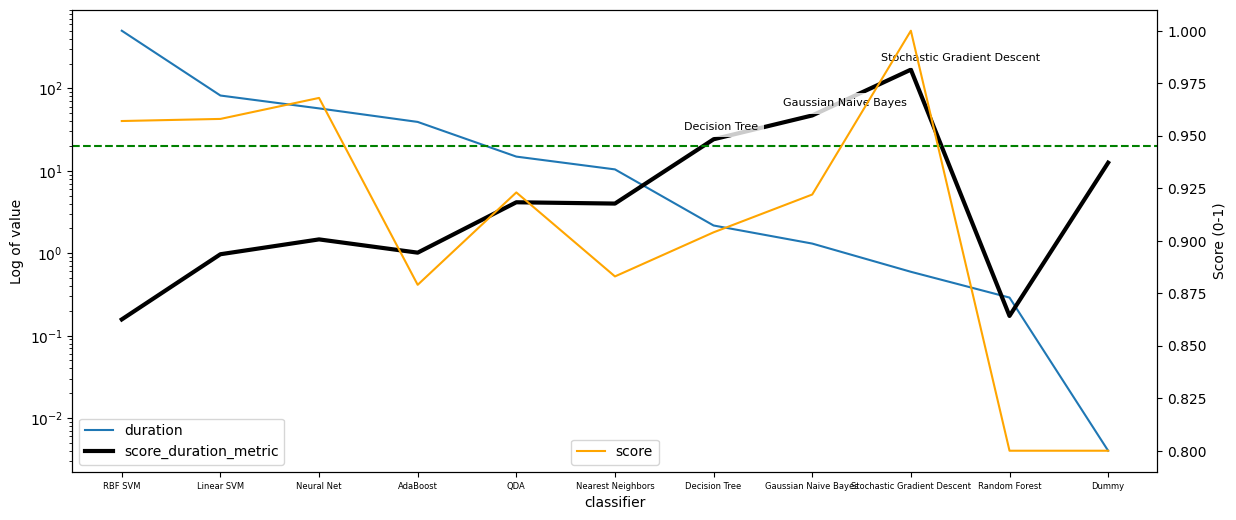

In [43]:
rdf = rdf.sort_values(by="duration", ascending=False).round(3)

fig, axs = plt.subplots(figsize=(14, 6), sharey=False)
axs.set_xticks(range(len(rdf)))
axs.set_xticklabels(rdf.classifier.values, fontsize=6)

ax2 = axs.twinx()
rdf.plot("classifier", "duration", ax=axs, logy=True)
rdf.plot("classifier", "score", ax=ax2, color="orange").legend(loc="lower center")
ax2.set_ylabel("Score (0-1)")
axs.set_ylabel("Log of value")
rdf.plot("classifier", "score_duration_metric", ax=axs, color="black", linewidth=3).legend(loc="lower left")

THRESHOLD = 20
axs.axhline(y=THRESHOLD, color ="green", linestyle='--')
for i, row in rdf[rdf["score_duration_metric"] > THRESHOLD].iterrows():
    text = axs.annotate(row.classifier, (list(rdf.classifier).index(row.classifier) - 0.3, row.score_duration_metric * 1.3),
                fontsize=8)
    text.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))

print("Top classifiers (at the top of the table), taking into account the duration (and CPU cost)...")
rdf.sort_values(by="score_duration_metric", ascending=False)

## Review of the best models

The Stochastic Gradient Descent, Naive Bayes and Decision Tree classifier looks like they get good results. Can we try them out on some test data?

In [44]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
print(f"SGD accuracy score: {sgd_clf.score(X_test, y_test):.3f}")

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
print(f"NB accuracy score: {nb_clf.score(X_test, y_test):.3f}")

dtree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree_clf.fit(X_train, y_train)
print(f"DT accuracy score: {dtree_clf.score(X_test, y_test):.3f}")

SGD accuracy score: 1.000
NB accuracy score: 0.922
DT accuracy score: 0.904


## Let's try these models to predict whether new file names are good or not

We now have 3 candidate classifiers. We can write a couple of functions to take in new file names and then predict whether they are classified as "good" or "bad". Let's see how they work:

In [45]:
def filename_to_record(filename):
    """
    Take a file name and return a one-hot-encoded `DataFrame`
    ready for use by a classifier.
    """
    df_newfile = ff.filename_to_df(filename)
    df_enc = one_hot_encoder.transform(df_newfile)
    return df_enc

def is_file_good(filename, classifier):
    """
    Does the `classifier` think that `filename` is good or bad.
    """
    rec = filename_to_record(filename)
    res = classifier.predict(rec)
    result = int(res[0])
    clf_name = classifier.__class__.__name__
    print(f"File: {filename} using {clf_name}:", ["BAD", "GOOD"][result])

Let's test some bad file names and see how they get on:

In [46]:
classifiers = (sgd_clf, nb_clf, dtree_clf)
bad_files = ("my_bye.txt", "duff", "pq_ukcp_60km_2010.nc")

for classifier in classifiers:
    for bad_file in bad_files:
        is_file_good(bad_file, classifier)

File: my_bye.txt using SGDClassifier: BAD
File: duff using SGDClassifier: BAD
File: pq_ukcp_60km_2010.nc using SGDClassifier: BAD
File: my_bye.txt using GaussianNB: BAD
File: duff using GaussianNB: BAD
File: pq_ukcp_60km_2010.nc using GaussianNB: GOOD
File: my_bye.txt using DecisionTreeClassifier: BAD
File: duff using DecisionTreeClassifier: BAD
File: pq_ukcp_60km_2010.nc using DecisionTreeClassifier: GOOD


**NOTE:** in the above, the **SGD classifier correctly identifies the last file as bad**, whereas the Decision Tree classifier failed to do so.

In [47]:
good_files = ("pr_ukcp_25km_2000.nc", "tasmax_cmip_60km_2020.csv", "slhf_era_100km_2030.nc")

for classifier in classifiers:
    for good_file in good_files:
        is_file_good(good_file, classifier)

File: pr_ukcp_25km_2000.nc using SGDClassifier: GOOD
File: tasmax_cmip_60km_2020.csv using SGDClassifier: GOOD
File: slhf_era_100km_2030.nc using SGDClassifier: GOOD
File: pr_ukcp_25km_2000.nc using GaussianNB: GOOD
File: tasmax_cmip_60km_2020.csv using GaussianNB: GOOD
File: slhf_era_100km_2030.nc using GaussianNB: GOOD
File: pr_ukcp_25km_2000.nc using DecisionTreeClassifier: GOOD
File: tasmax_cmip_60km_2020.csv using DecisionTreeClassifier: GOOD
File: slhf_era_100km_2030.nc using DecisionTreeClassifier: GOOD


## Should we introduce Nested Cross-Validation to this example?

Here is a good example: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

In [ ]:
# automatic nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# create dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=1, n_informative=10, n_redundant=10)

# configure the inner cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

# define the model
model = RandomForestClassifier(random_state=1)

# define search space
space = {
    'n_estimators': [10, 100, 500],
    'max_features': [2, 4, 6]
}

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)

# configure the outer cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))